In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import largestinteriorrectangle as lir

In [2]:
# 利用随机数据, 生成凸包  image_size: 图像尺寸 
def generate_convex_polygon(image_size=64, num_points=9):
    # 生成随机点
    points = np.random.randint(0, image_size, (num_points, 2))
    
    # 计算凸包
    hull = ConvexHull(points)
    
    # 返回凸包的顶点
    return points[hull.vertices]

In [3]:
def generate_random_polygon_image(image_size=64, num_points=6):
    # 生成随机的多边形顶点
    points = generate_convex_polygon(image_size, num_points)
    # 创建空白图像
    image = np.zeros((image_size, image_size), dtype=np.uint8)
    # 画出多边形
    cv2.fillPoly(image, [points], 255)
    # 返回多边形图像和顶点（在真实问题中，你可能希望返回内接矩形的标签）
    return image, points

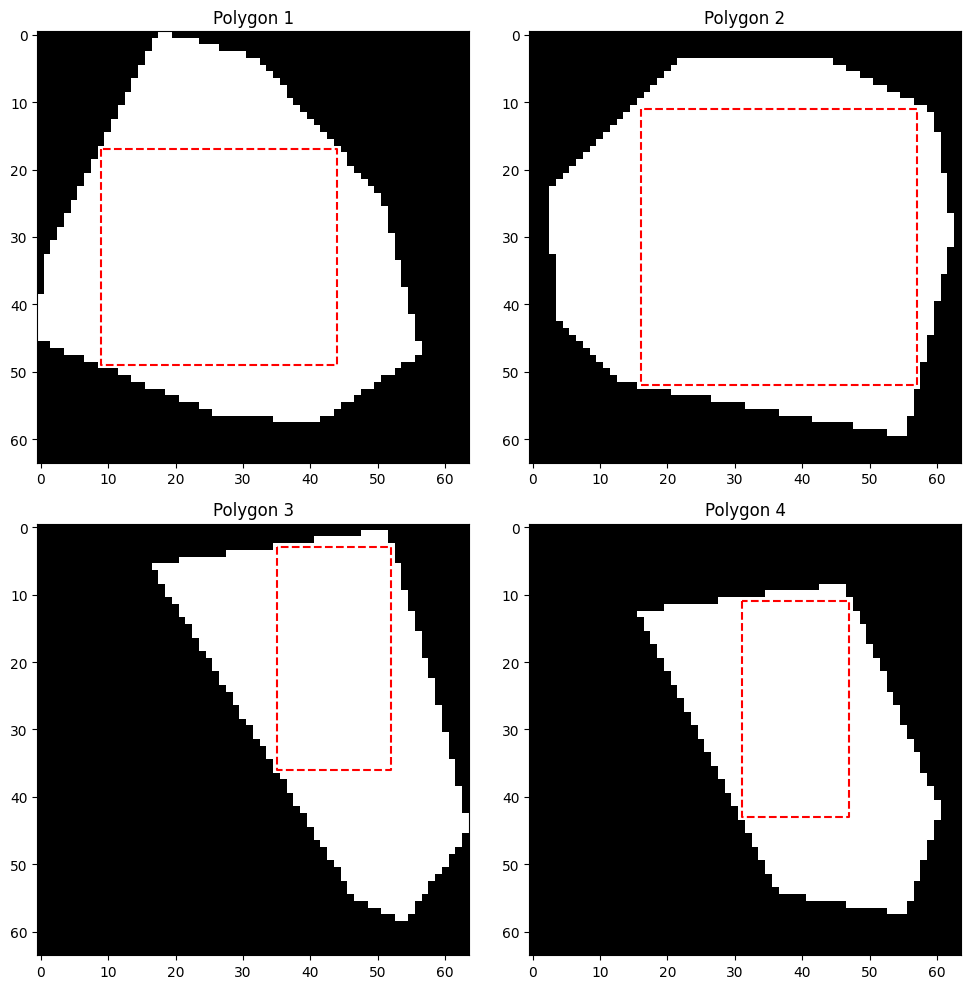

In [4]:
# 创建画布和子图
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# 将子图展平为一维数组
axs = axs.flatten()
point_range=[5,21]
for i in range(4):  
    num_points = np.random.randint(point_range[0], point_range[1])
    image, _ = generate_random_polygon_image(image_size=64, num_points=num_points)
    # point =  lir.lir(image.astype('bool')) # array([2, 2, 4, 7])
    point =  lir.lir(image.astype('bool')) # array([2, 2, 4, 7])
    rect = np.array([(point[0],point[1]), (point[0],point[1]+point[3]-1), (point[0]+point[2]-1,point[1]+point[3]-1),(point[0]+point[2]-1,point[1])])
    rect = np.vstack([rect, rect[0]])  # 关上矩形的最后一条边
    axs[i].plot(rect[:, 0], rect[:, 1], 'r--')    
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(f'Polygon {i+1}')
    axs[i].set_aspect('equal', 'box')  # 设置坐标轴比例相同
        
# 调整子图之间的间距
plt.tight_layout()

# 显示图像
plt.show()

In [5]:
# 生成训练数据 (多边形和最大内接矩形参数)
def generate_training_data(num_samples=1000, image_size=64, point_range=[5,21]) :
    data = []
    for _ in range(num_samples):
        num_points = np.random.randint(point_range[0], point_range[1])
        image, _ = generate_random_polygon_image(image_size=image_size, num_points=9)
        point =  lir.lir(image.astype('bool')) # array([2, 2, 4, 7])
        data.append((image.flatten(), np.array([point[0], point[1], point[2], point[3]])))
    return data

In [6]:
%%time
import os
import pickle

# 保存为二进制文件
file_path = "data.pkl"
train_data = None
if os.path.exists(file_path):
    print("从文件导入训练数据")
    with open(file_path, 'rb') as file:
        train_data = pickle.load(file)  # 这里应该传递文件对象，而不是文件路径
else:
    print("生成训练数据")
    train_data = generate_training_data(10000)
    with open(file_path, 'wb') as file:
        pickle.dump(train_data, file)

从文件导入训练数据
CPU times: total: 125 ms
Wall time: 209 ms


In [7]:
train_data[0:2], len(train_data)

([(array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
   array([33, 14, 22, 30], dtype=uint32)),
  (array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
   array([11, 28, 37, 26], dtype=uint32))],
 10000)

In [8]:
# 展示生成的多边形
def display_polygon_image_x(image, rectangle):
    rect = np.array([(rectangle[0],rectangle[1]), 
                     (rectangle[0],rectangle[1]+rectangle[3]-1), 
                     (rectangle[0]+rectangle[2]-1,rectangle[1]+rectangle[3]-1),
                     (rectangle[0]+rectangle[2]-1,rectangle[1])])
    rect = np.vstack([rect, rect[0]])  # 关上矩形的最后一条边
    
    # 显示图像
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')  # 灰度图像
    plt.plot(rect[:, 0], rect[:, 1], 'r--')
    # plt.scatter(points[:, 0], points[:, 1], color='red')  # 标记多边形的顶点
    plt.title('Random Polygon')
    plt.show()

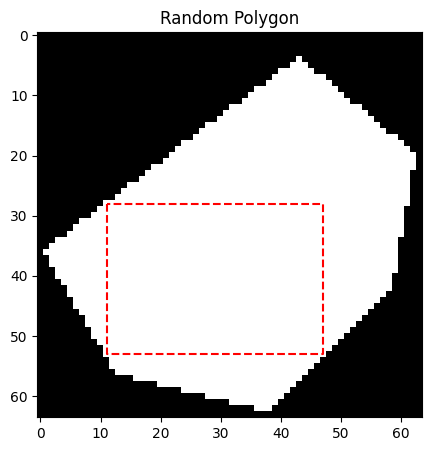

In [9]:
display_polygon_image_x(train_data[1][0].reshape(64,64),train_data[1][1])

In [10]:
dataset = TensorDataset(torch.tensor([x[0] for x in train_data], dtype=torch.float32), torch.tensor([x[1] for x in train_data], dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

C:\Users\loki_\AppData\Local\Temp\ipykernel_11700\596144479.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  dataset = TensorDataset(torch.tensor([x[0] for x in train_data], dtype=torch.float32), torch.tensor([x[1] for x in train_data], dtype=torch.float32))


In [19]:
# 简单的全连接神经网络
class RectNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(RectNet, self).__init__()
        self.model = nn.Sequential(
            # expand 1 to 10 filters
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),       
            nn.LeakyReLU(0.02),
            # nn.Dropout(0.5),      # Dropout 层
        
            # 10 filters to 10 filters
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),          
            nn.LeakyReLU(0.02),    
            # nn.Dropout(0.3),      # Dropout 层
            nn.Linear(64, output_size)
        )
        
    def forward(self, x):
        # x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        # x = self.fc3(x)
        # return x
        return self.model(x)

In [12]:
len(train_data[0][0])

4096

In [20]:
model = RectNet(input_size=len(train_data[0][0]), output_size=4)

In [21]:
# 优化器 - Adam，学习率为0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)
# 学习率调度器 - 每10个epoch降低学习率
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.MSELoss()

In [22]:
# 训练模型
def train(model, dataloader, criterion, optimizer, scheduler, num_epochs=50):
    model.train()  # 训练模式
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in dataloader:
            optimizer.zero_grad()  # 清空梯度
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            
            # 反向传播
            loss.backward()
            
            # 梯度裁剪，防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()  # 更新权重
            
            running_loss += loss.item()
        
        # 学习率调度
        scheduler.step()
        
        # 打印每个epoch的平均损失
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")

In [39]:
train(model, dataloader, criterion, optimizer, scheduler, num_epochs=20)

Epoch [1/20], Loss: 6.0585
Epoch [2/20], Loss: 6.0560
Epoch [3/20], Loss: 6.0219
Epoch [4/20], Loss: 6.1579
Epoch [5/20], Loss: 6.1624
Epoch [6/20], Loss: 6.1856
Epoch [7/20], Loss: 5.8966
Epoch [8/20], Loss: 6.2120
Epoch [9/20], Loss: 5.9897
Epoch [10/20], Loss: 6.1466
Epoch [11/20], Loss: 6.1795
Epoch [12/20], Loss: 6.1878
Epoch [13/20], Loss: 6.2106
Epoch [14/20], Loss: 6.3484
Epoch [15/20], Loss: 6.1403
Epoch [16/20], Loss: 6.1747
Epoch [17/20], Loss: 6.1173
Epoch [18/20], Loss: 6.0925
Epoch [19/20], Loss: 6.2258
Epoch [20/20], Loss: 6.0928


In [23]:
num_points = np.random.randint(point_range[0], point_range[1])
testimages, _ = generate_random_polygon_image(image_size=64, num_points=9)

*************************
point = [ 7.940188 17.184525 43.10329  41.185135]
real_point = [14 22 43 37]
loss = 19.359037399291992
hand loss = [ 6.05981207  4.81547546 -0.10329056 -4.18513489]
*************************
point = [ 4.0203257  7.47909   52.24152   50.376404 ]
real_point = [ 2 10 58 50]
loss = 10.934618949890137
hand loss = [-2.02032566  2.52090979  5.75848007 -0.37640381]
*************************
point = [ 6.790122   4.9514785 44.223682  50.469307 ]
real_point = [ 6  8 45 45]
loss = 10.108440399169922
hand loss = [-0.79012203  3.04852152  0.7763176  -5.46930695]
*************************
point = [ 8.822665   1.7235944 45.850784  57.81923  ]
real_point = [ 9  2 48 58]
loss = 1.1899135112762451
hand loss = [0.17733479 0.27640557 2.1492157  0.18077087]


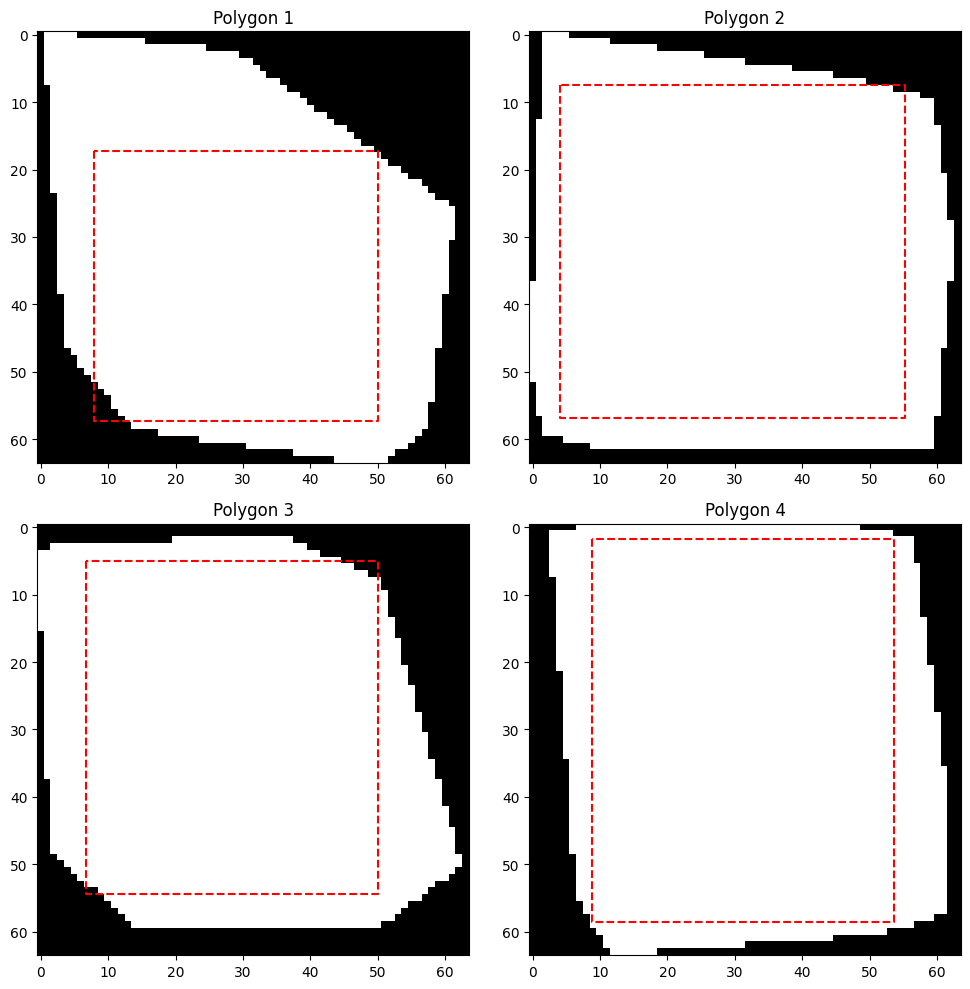

In [43]:
# 生成4个凸多边形
model.eval()

# 创建画布和子图
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# 将子图展平为一维数组
axs = axs.flatten()
for i in range(4):
    # num_points = np.random.randint(point_range[0], point_range[1])
    num_points = np.random.randint(21, 36)
    image, _ = generate_random_polygon_image(image_size=64, num_points=num_points)
    # image = train_data[i+4][0].reshape(64,64)
    real_point =  lir.lir(image.astype('bool')) # array([2, 2, 4, 7])
    # data.append((image.flatten(), np.array([point[0], point[1], point[2], point[3]])))
    with torch.no_grad():
        test_input = torch.tensor(image.flatten(), dtype=torch.float32).unsqueeze(0)
        # point = model(test_input).squeeze().numpy()
        output = model(test_input)
        # print(f"output = {output}  | output.squeeze = {output.squeeze()} ") 
        # print(f"type(output.squeeze())  = {output.squeeze().shape} ")
        # print(f"type(real_point)  = {real_point.shape} ")
        # break
        loss = criterion(output.squeeze(), torch.tensor(real_point, dtype=torch.float32))      
        point = output.squeeze().numpy()
        print("*"*25)
        print(f"point = {point}")
        print(f"real_point = {real_point}")
        print(f"loss = {loss}")
        # print(f"hand loss = {sum((real_point - point)**2)/4}")
        print(f"hand loss = {real_point - point}")
    rect = np.array([(point[0],point[1]), (point[0],point[1]+point[3]-1), (point[0]+point[2]-1,point[1]+point[3]-1),(point[0]+point[2]-1,point[1])])
    rect = np.vstack([rect, rect[0]])  # 关上矩形的最后一条边
    axs[i].plot(rect[:, 0], rect[:, 1], 'r--')    
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title(f'Polygon {i+1}')
    axs[i].set_aspect('equal', 'box')  # 设置坐标轴比例相同
        
# 调整子图之间的间距
plt.tight_layout()

# 显示图像
plt.show()